# Toan Luong

* Updated May 25, 2018

# Q1

* In the `obj()` function, given K and y, I computed the objective function with the huberized hinge loss just as the previous homework using masking. The difference is working with the gram matrix K and the regularization term is $\lambda \beta^T K \beta$. **Please note that, for consistency purposes, $\beta$ in this notebook refers to the linear weights $\alpha$ that we need to search to minimize the defined cost function**.
* Similar to the previous homework, the `grad()` function computes the analytical gradient given the loss function applied to the gram matrix K. Masking methods are also applied here.

In [1]:
def obj(beta, K, y, lam, h=0.5):
    """
    Inputs:
    - beta: Vector to be optimized
    - K: Gram matrix consisting of evaluations of the kernel k(x_i, x_j) for i,j=1,...,n
    - y: Labels y_1,...,y_n corresponding to x_1,...,x_n
    - lam: Penalty parameter lambda
    Output:
    - Value of the objective function at beta
    """
    
    cost_vector = np.zeros(y.shape[0])
    t = K.dot(beta)
    yt = y * t
    cost_vector[yt < 1-h] = (1 - yt[yt < 1 - h])
    cost_vector[np.absolute(1 - yt) <= h] = (((1 + h - yt[np.absolute(1 - yt) <= h])**2) / (4 * h))
    return (1/y.shape[0]) * np.sum(cost_vector) + lam * beta.dot(K).dot(beta)

def grad(beta, K, y, lam, h=0.5):
    """
    Inputs:
    - beta: Vector to be optimized
    - K: Gram matrix consisting of evaluations of the kernel k(x_i, x_j) for i,j=1,...,n
    - y: Labels y_1,...,y_n corresponding to x_1,...,x_n
    - lam: Penalty parameter lambda
    Output:
    - Value of the gradient at beta
    """
    grad_matrix = np.zeros((y.shape[0], y.shape[0]))
    t = K.dot(beta)
    yt = y * t
    grad_matrix[yt < 1 - h] = (-y[:, np.newaxis] * K)[yt < 1 - h]
    grad_matrix[np.absolute(1 - yt) <= h] = (((-2 / (4 * h)) * (1 + h - yt))[:, np.newaxis] * (y[:, np.newaxis] * K))[np.absolute(1 - yt) <= h]
    return 1/y.shape[0] * np.sum(grad_matrix, axis=0) + 2 * lam * K.dot(beta)

* Using the numerical gradient checking module from Lab 8, I was able to pass the test for all the beta/alpha values. This means the gradient calculation is accurate.

In [3]:
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

def test_grad(eps=1e-6):
    n = 5
    for i in range(n):
        np.random.seed(0)
        beta = -np.random.normal(size=n)
        x = np.random.randn(n, n)
        K = sklearn.metrics.pairwise.rbf_kernel(x, x)
        y = np.random.choice([0, 1], size=5)
        lam = 0.5
        f1 = obj(beta, K, y, lam)
        beta[i] = beta[i] + eps
        f2 = obj(beta, K, y, lam)
        print('Estimated and calculated values of beta[', i, ']:', (f2-f1)/eps, grad(beta, K, y, lam)[i])
        assert np.isclose((f2-f1)/eps, grad(beta, K, y, lam)[i]), 'Estimated gradient ' + str((f2-f1)/eps) + ' is not approximately equal to the computed gradient ' + str(grad(beta, K, y, lam)[i])
    print('Test passed')
test_grad()

Estimated and calculated values of beta[ 0 ]: -3.9762924295416724 -3.976291931217144
Estimated and calculated values of beta[ 1 ]: -2.8500102207118516 -2.8500097235215462
Estimated and calculated values of beta[ 2 ]: -2.5292395413600843 -2.529239045585945
Estimated and calculated values of beta[ 3 ]: -3.0770301062688077 -3.0770296084350526
Estimated and calculated values of beta[ 4 ]: -3.1989823696676467 -3.1989818742503555
Test passed


* Inspired from the code from Lab 8, the `gram()` method computes the gram matrix given input matrices X and Z. The `rbf` kernel is computed similar to the Lab exercise. The formula is given as $$ k(x,y) = \exp\left(-\frac{1}{2\sigma^2}\|x-y\|^2\right).$$
* The `linear` and `poly` kernel is very to figure out by using dot product and $b = 1$.

In [4]:
def gram(X, Z=None, kernel_choice='rbf', sigma=0.5, order=2):
    """
    Inputs: 
    - X: matrix with observations as rows
    - Z: Another matrix with observations as rows
    - Sigma: kernel bandwidth
    Output: Gram matrix
    """  
    if Z is None:
        Z = X
    if kernel_choice == 'rbf':
        return np.exp(-1/(2*sigma**2)*((np.linalg.norm(X, axis=1)**2)[:, np.newaxis] + (np.linalg.norm(Z, axis=1)**2)[np.newaxis, :] - 2*np.dot(X, Z.T)))
    elif kernel_choice == 'linear':
        return X.dot(Z.T)
    elif kernel_choice == 'poly':
        return (X.dot(Z.T) + 1)**order
    else:
        print("Kernel Not Implemented")
        return X

* Using the Gram Checking module from Lab 8, the RBF and linear kernel results computed by my own `gram()` function are similar to those of `sklearn.metrics.pairwise`.

In [5]:
def test_gram():  
    np.random.seed(0)
    X = np.random.randn(6, 5)
    Z = np.random.randn(7, 5)
    sigma = 10
    gram1 = gram(X, Z, sigma=sigma)
    gram2 = sklearn.metrics.pairwise.rbf_kernel(X, Z, gamma=1/(2*sigma**2))
    assert np.allclose(gram1, gram2), 'Computed matrix' + str(gram1) + 'does not match that of scikit-learn:' + str(gram2)
    print('RBF passed')
    gram3 = gram(X, Z, kernel_choice='linear')
    gram4 = sklearn.metrics.pairwise.linear_kernel(X, Z)
    assert np.allclose(gram1, gram2), 'Computed matrix' + str(gram1) + 'does not match that of scikit-learn:' + str(gram2)
    print('Linear passed')
test_gram()

RBF passed
Linear passed


* Below is the main fast gradient descent pipeline that we have been doing for the past few homework. The code is edited from Lab 8 with several small tweaks.

In [6]:
def bt_line_search(beta, K, y, lam, eta=1, alpha=0.5, betaparam=0.8, maxiter=100):
    grad_beta = grad(beta, K, y, lam)
    norm_grad_beta = np.linalg.norm(grad_beta)
    found_eta = 0
    iter = 0
    while found_eta == 0 and iter < maxiter:
        if obj(beta - eta * grad_beta, K, y, lam) < \
                        obj(beta, K, y, lam) - alpha * eta * norm_grad_beta ** 2:
            found_eta = 1
        elif iter == maxiter-1:
            raise ('Max number of iterations of backtracking line search reached')
        else:
            eta *= betaparam
            iter += 1
    return eta

def fastgradalgo(beta_init, theta_init, K, y, lam, eta_init, maxiter, eps=1e-5):
    beta = beta_init
    theta = theta_init
    eta = eta_init
    grad_theta = grad(theta, K, y, lam)
    grad_beta = grad(beta, K, y, lam)
    beta_vals = beta
    iter = 0
    while iter < maxiter and np.linalg.norm(grad_beta) > eps:
        eta = bt_line_search(theta, K, y, lam, eta=eta)
        beta_new = theta - eta*grad_theta
        theta = beta_new + iter/(iter+3)*(beta_new-beta)
        grad_theta = grad(theta, K, y, lam)
        grad_beta = grad(beta, K, y, lam)
        beta = beta_new
        iter += 1
        if iter % 1 == 0:
            beta_vals = np.vstack((beta_vals, beta_new))
    return beta_vals

def objective_plot(betas, K, y, lam):
    num_points = np.size(betas, 0)
    objs = np.zeros(num_points)
    for i in range(0, num_points):
        objs[i] = obj(betas[i, :], K, y, lam)
    fig, ax = plt.subplots()
    ax.plot(np.array(range(num_points)), objs, c='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Objective value')
    ax.set_title('Objective value vs. iteration when lambda=' + str(lam))
    return ax

* `mylinearsvm()` combines all the above elements to perform the training process. `sigma` and `order` are optinal arguments if kernel choice is rbf or polynomial. If `sigma` is not specified, it will be computed on the median of the pairwise distances. The rest of the code is standard and `fastgradalgo()` is applied to the Gram matrix denoted as K. 

In [23]:
import scipy.linalg
def mylinearsvm(X_train, y_train, lam=1, **config):
    sigma = None
    order = None
    kernel_choice = config['kernel_choice']
    if 'sigma' in config:
        sigma = config['sigma']
    if 'order' in config:
        order = config['order']
    n, d = X_train.shape
    cache = {}
    beta_init = np.zeros(n)
    theta_init = np.zeros(n)
    if sigma is None and kernel_choice=='rbf':
        dists = sklearn.metrics.pairwise.pairwise_distances(X_train).reshape(-1)
        sigma = np.median(dists)
    K = gram(X_train, X_train, kernel_choice, sigma=sigma, order=order)
    # Set eta_init based on an upper bound on the Lipschitz constant
    eta_init = 1 / scipy.linalg.eigh(2 / n * np.dot(K, K) + 2 * lam * K, eigvals=(n - 1, n - 1),
                                     eigvals_only=True)[0]
    beta_vals = fastgradalgo(beta_init, theta_init, K, y_train, lam, eta_init, config['max_iter'])
    if config['plot']:
        ax = objective_plot(beta_vals, K, y_train, lam)
        cache['plot'] = ax
    cache['sigma'] = sigma
    cache['order'] = order
    cache['eta_init'] = eta_init
    return beta_vals, cache

* Next, I load the Digits dataset, perform a train/test split, and standardize based on the training set.

In [14]:
from sklearn.datasets import load_digits
digits = load_digits() 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

num_images = digits.images.shape[0]

X_train, X_test, y_train, y_test = train_test_split(digits.images.reshape(num_images, -1), digits.target, test_size=.4, random_state=42)

#Standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Number of training examples:', X_train.shape)
print('Number of test examples:', X_test.shape)

Number of training examples: (1078, 64)
Number of test examples: (719, 64)


* Below is the main API to perform Huber SVM for multi-class classfication task. The method choice can be one-vs-one `ovo` or one-vs-rest `ovr`.
* `predict()` will take in a trained beta/alpha weights, `X_train`, `X_test`, and the kernel choice, sigma/order config from the training process to compute prediction. Scores or `y_vals` is computed as the dot product of kernel(X_test example i, X_train) with the trained weights. The kernel choice and parameter is flexible, and default as Linear Kernel.
* `train_predict()` will take in train and test dataset to compute final predictions and misclassification errors. For OVO, voting will be based on the mode of the predicted classes across 45 classfiers. For OVR, voting will be based on the argmax of the score across 10 classifiers.

In [15]:
from tqdm import tqdm
import itertools
import numpy as np
from scipy.stats import mode

def filter_pair(label_pair, x, y):
    """ Filter a multi-class dataset into binary dataset given a label pair.
    """
    mask = np.isin(y, label_pair)
    x_bin, y_bin = x[mask].copy(), y[mask].copy()
    y_bin[y_bin==label_pair[0]] = 1.0
    y_bin[y_bin==label_pair[1]] = -1.0
    return x_bin, y_bin

def predict(beta, X_train, X_test, kernel, **kwargs):
    n_test = X_test.shape[0]
    y_vals = np.zeros(n_test)
    for i in range(n_test):
        if 'kernel_choice' in kwargs:
            kernel_choice = kwargs['kernel_choice']
            if kernel_choice == 'rbf' and 'sigma' in kwargs:
                y_vals[i] = np.dot(kernel(X_train, X_test[i, :].reshape(1, -1), kernel_choice, sigma=kwargs['sigma']).reshape(-1), beta)
            elif kernel_choice == 'poly' and 'order' in kwargs:
                y_vals[i] = np.dot(kernel(X_train, X_test[i, :].reshape(1, -1), kernel_choice, order=kwargs['order']).reshape(-1), beta)
        else:
            y_vals[i] = np.dot(kernel(X_train, X_test[i, :].reshape(1, -1), kernel_choice='linear').reshape(-1), beta)
    return y_vals

def train_predict(X_train, y_train, X_test, y_test, lam, method='ovo', **config):
    error = None
    label_list = np.unique(y_train)
    if method == 'ovo':
        pred_list = []
        label_pair_list = list(itertools.combinations(label_list, 2))
        for label_pair in tqdm(label_pair_list):
            X_train_bin, y_train_bin = filter_pair(label_pair, X_train, y_train)
            beta_vals, train_cache = mylinearsvm(X_train_bin, y_train_bin, lam, **config)
            if config['plot']:
                plt.show(train_cache['plot'])
            scores = predict(beta_vals[-1, :], X_train_bin, X_test, gram, **train_cache)
            y_pred_bin = np.zeros_like(y_test) + label_pair[-1]
            y_pred_bin[scores >= 0] = label_pair[0]
            pred_list.append(y_pred_bin)
        test_preds = np.array([mode(pi).mode[0] for pi in np.array(pred_list, dtype=np.int64).T])
        error = np.mean(test_preds != y_test)
    elif method == 'ovr':
        score_list = []
        for label in tqdm(label_list):
            y_train_bin = np.zeros_like(y_train) - 1
            y_train_bin[y_train == label] = 1
            beta_vals, train_cache = mylinearsvm(X_train, y_train_bin, lam, **config)
            if config['plot']:
                plt.show(train_cache['plot'])
            scores = predict(beta_vals[-1, :], X_train, X_test, gram, **train_cache)
            score_list.append(scores)
        test_preds = np.argmax(np.stack(score_list, axis=1), axis=1)
        error = np.mean(test_preds != y_test)
    else:
        print("Method Not Implemented")
    return error, beta_vals

* Let's look at a few trial runs of One-Vs-Rest with plots.
* For **polynomial kernel with order 7**, the misclassification error is very bad and converges to 0.7469 after 200 iterations. For every individual classifier, the objective value descends nicely but to a very small attitude.

100%|██████████| 10/10 [02:26<00:00, 14.43s/it]


Lambda = 1.0000. Misclassification Error = 0.7469


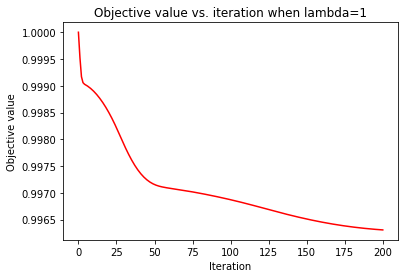

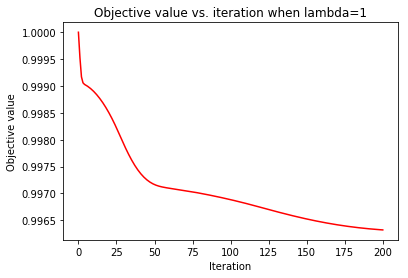

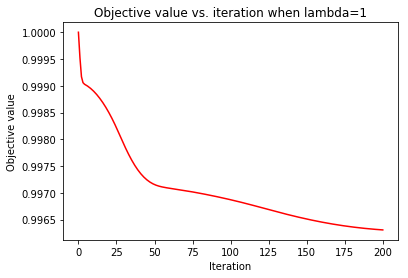

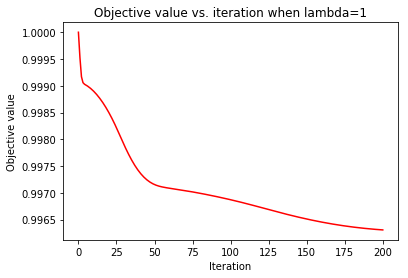

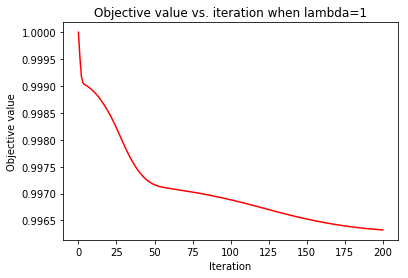

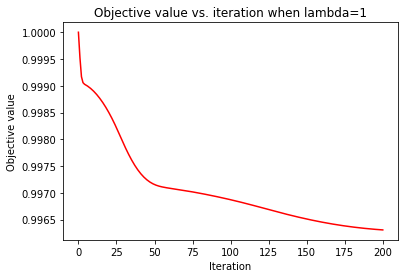

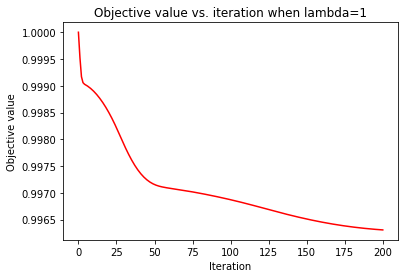

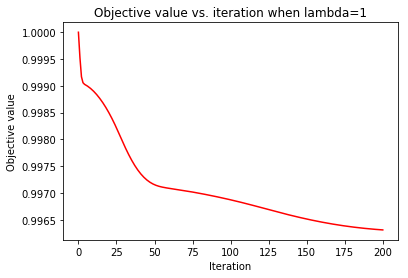

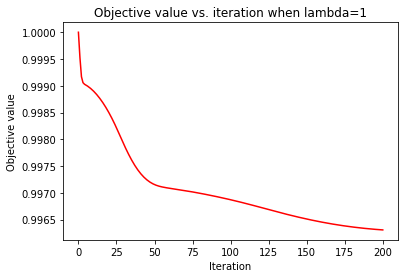

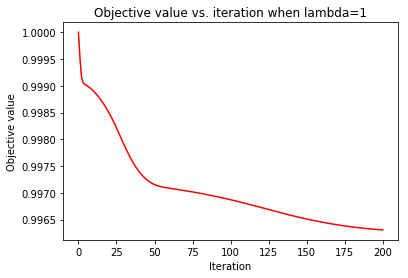

In [10]:
lambda_list = [1]
for l in lambda_list:
    error, beta_vals = train_predict(X_train, y_train, X_test, y_test, lam=l, method='ovr', **{'kernel_choice': 'poly', 'order': 7, 'plot': True, 'max_iter': 200})
    print("Lambda = %0.4f. Misclassification Error = %0.4f" %(l, error))

* **For rbf kernel** with **median(dists) as sigma**, the final misclassification error is much better and converges at 0.1641 after 200 iterations. The plots show a quick descent after less than 10 iterations. The simpler representation, compared to polynomial order 7 kernel, might contribute to better learning result.

100%|██████████| 10/10 [02:26<00:00, 14.55s/it]


Lambda = 1.0000. Misclassification Error = 0.1641


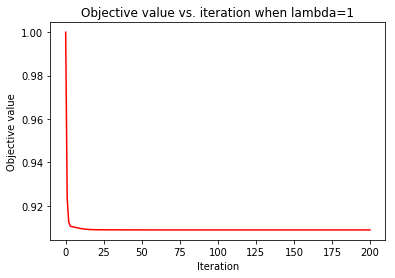

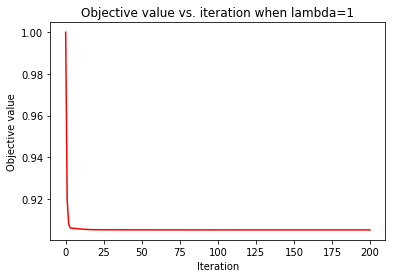

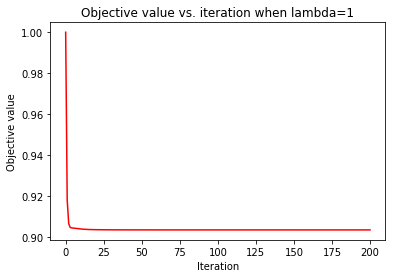

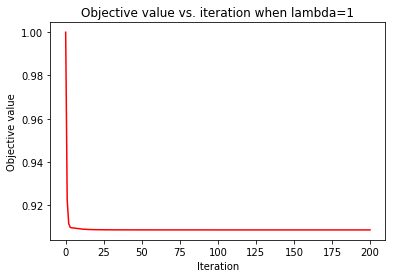

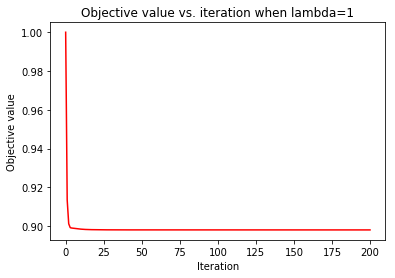

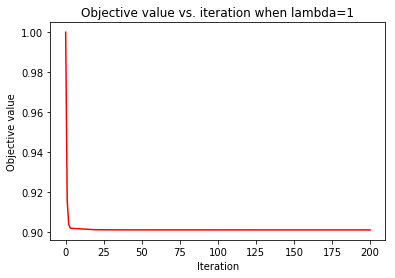

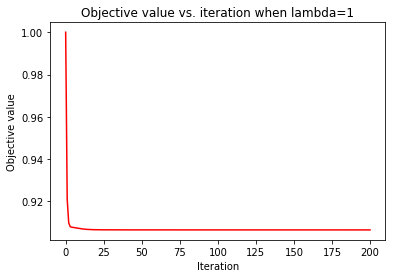

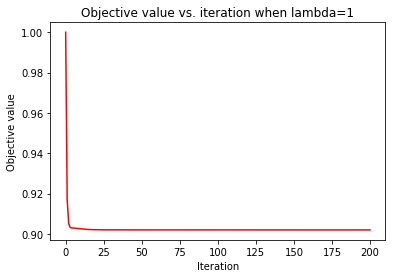

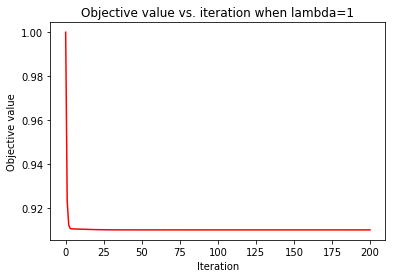

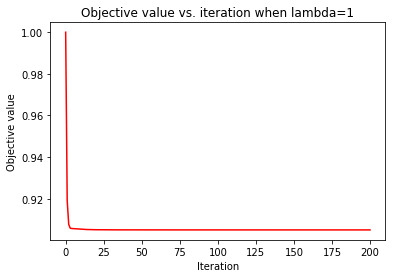

In [11]:
lambda_list = [1]
for l in lambda_list:
    error, beta_vals = train_predict(X_train, y_train, X_test, y_test, lam=l, method='ovr', **{'kernel_choice': 'rbf', 'plot': True, 'max_iter': 200})
    print("Lambda = %0.4f. Misclassification Error = %0.4f" %(l, error))

* As expected, **for linear kernel**, the final misclassification error is the best among all 3 kernel types and converges at 0.1182 after 200 iterations. The plots show a quick descent after less than 25 iterations and every classifer converges to an objective value of 0.84. Learning is much better with a simpler representation.

100%|██████████| 10/10 [01:52<00:00, 11.23s/it]


Lambda = 1.0000. Misclassification Error = 0.1182


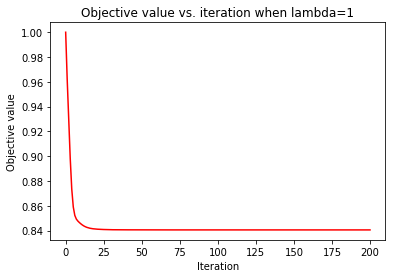

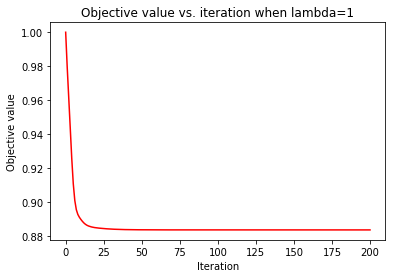

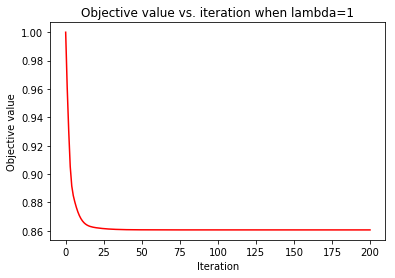

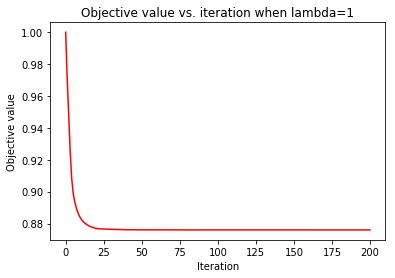

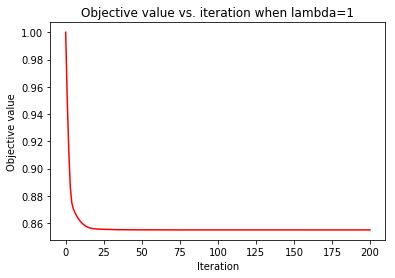

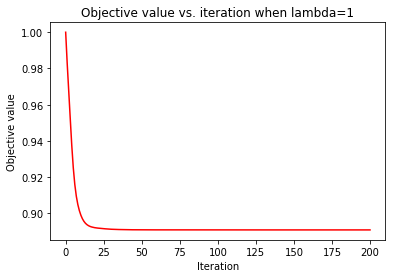

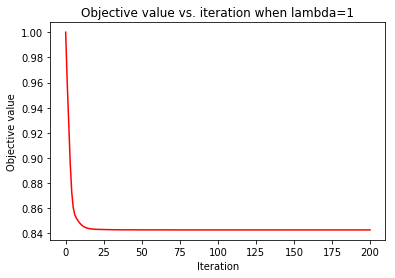

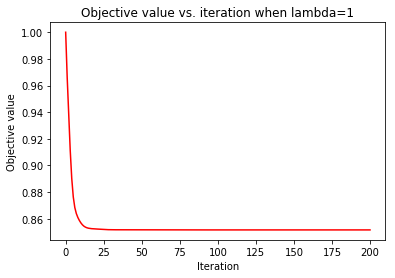

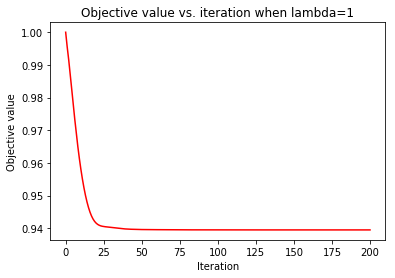

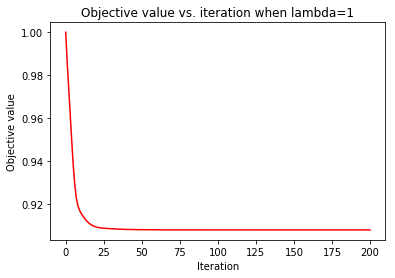

In [12]:
lambda_list = [1]
for l in lambda_list:
    error, beta_vals = train_predict(X_train, y_train, X_test, y_test, lam=l, method='ovr', **{'kernel_choice': 'linear', 'plot': True, 'max_iter': 200})
    print("Lambda = %0.4f. Misclassification Error = %0.4f" %(l, error))

* Now, we switch gear to One-vs-One to perform cross-validation with different values of $\lambda$
* Below is the result using **RBF kernels**. Apparently, the misclassfication error increases as $\lambda$ increases. The optimal value of $\lambda$ is 0.0098 that yields 0.1252 misclassification error.

In [16]:
lambda_list = np.logspace(start=-10, stop=5, num=10, base=2)
for l in lambda_list:
    error, beta_vals = train_predict(X_train, y_train, X_test, y_test, lam=l, method='ovo', **{'kernel_choice': 'rbf', 'plot': False, 'max_iter': 100})
    print("Lambda = %0.4f. Misclassification Error = %0.4f" %(l, error))

  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0010. Misclassification Error = 0.1460


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0031. Misclassification Error = 0.1321


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0098. Misclassification Error = 0.1252


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0312. Misclassification Error = 0.1433


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0992. Misclassification Error = 0.1599


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.3150. Misclassification Error = 0.1641


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 1.0000. Misclassification Error = 0.1641


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 3.1748. Misclassification Error = 0.1641


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 10.0794. Misclassification Error = 0.1641


100%|██████████| 45/45 [00:13<00:00,  3.42it/s]

Lambda = 32.0000. Misclassification Error = 0.1641


* Below is the result using **Poly kernels with Order 7**. The misclassfication error is the same for all $\lambda$ values. They all yield a 0.6426 misclassification error, which is better than One-Vs-Rest methods. But worse than other kernels.

In [20]:
lambda_list = np.logspace(start=-10, stop=5, num=10, base=2)
for l in lambda_list:
    error, beta_vals = train_predict(X_train, y_train, X_test, y_test, lam=l, method='ovo', **{'kernel_choice': 'poly', 'order': 7, 'plot': False, 'max_iter': 200})
    print("Lambda = %0.4f. Misclassification Error = %0.4f" %(l, error))


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0010. Misclassification Error = 0.6426


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0031. Misclassification Error = 0.6426


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0098. Misclassification Error = 0.6426


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0312. Misclassification Error = 0.6426


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0992. Misclassification Error = 0.6426


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.3150. Misclassification Error = 0.6426


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 1.0000. Misclassification Error = 0.6426


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 3.1748. Misclassification Error = 0.6426


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 10.0794. Misclassification Error = 0.6426


100%|██████████| 45/45 [00:19<00:00,  2.44it/s]

Lambda = 32.0000. Misclassification Error = 0.6426


* Below is the result using **Linear kernel**. The misclassfication error seems to increase as the $\lambda$ value increases. The most optimal $\lambda = 0.0312$ yields a 0.0195 misclassification error or more than 98% accuracy, which is very good for this particular dataset.

In [22]:
lambda_list = np.logspace(start=-10, stop=5, num=10, base=2)
for l in lambda_list:
    error, beta_vals = train_predict(X_train, y_train, X_test, y_test, lam=l, method='ovo', **{'kernel_choice': 'linear', 'plot': False, 'max_iter': 200})
    print("Lambda = %0.4f. Misclassification Error = %0.4f" %(l, error))


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0010. Misclassification Error = 0.0264


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0031. Misclassification Error = 0.0250


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0098. Misclassification Error = 0.0264


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0312. Misclassification Error = 0.0195


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.0992. Misclassification Error = 0.0209


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 0.3150. Misclassification Error = 0.0348


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 1.0000. Misclassification Error = 0.0598


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 3.1748. Misclassification Error = 0.1071


  0%|          | 0/45 [00:00<?, ?it/s]

Lambda = 10.0794. Misclassification Error = 0.1516


100%|██████████| 45/45 [00:19<00:00,  2.34it/s]

Lambda = 32.0000. Misclassification Error = 0.1641


# Q2

* The dataset is generated in the shape of `(30,60)` for 3 classes.

In [16]:
x1 = 2 * np.random.randn(30, 60) + 5
y1 = np.zeros(30) + 1
x2 = 1.5 * np.random.randn(30, 60) + 10
y2 = np.zeros(30) + 2
x3 = 1.2 * np.random.randn(30, 60) + 0.5
y3 = np.zeros(30) + 3
x = np.vstack([x1, x2, x3])
y = np.hstack([y1, y2, y3])
print(x.shape, y.shape)

(90, 60) (90,)


* After performing PCA using sklearn and transforming the 60-feature dataset into 2-feature dataset, the plot shows 3 distinct regions of the classes.

In [17]:
# SKLearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(x)
x_pca = pca.transform(x)

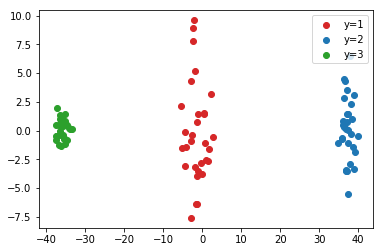

In [18]:
plt.scatter(x_pca[:30, 0], x_pca[:30, 1], color='tab:red', label='y=1')
plt.scatter(x_pca[30:60, 0], x_pca[30:60, 1], color='tab:blue', label='y=2')
plt.scatter(x_pca[60:, 0], x_pca[60:, 1], color='tab:green', label='y=3')
plt.legend(loc='upper right')

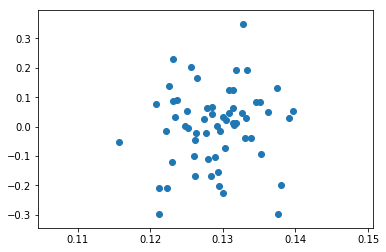

In [19]:
plt.scatter(pca.components_[0], pca.components_[1])

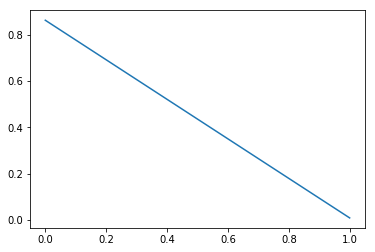

In [20]:
plt.plot(pca.explained_variance_ratio_)

* Below is the implementation of Oja PCA algorithm. It is essentially to learn a `w` weight with L2-norm equal to 1. By setting `k=2`, I "trained" the first 2 principal components.

In [42]:
def oja_pca(X, k, eta, max_iter=1000):
    n, d = X.shape
    w = np.random.randn(d, k)
    w /= np.linalg.norm(w, ord=2)
    for _ in range(max_iter):
        w += eta * (X.T.dot(X)).dot(w)
        w /= np.linalg.norm(w, ord=2)
    return w

w_out = oja_pca(x, k=2, eta=0.1)

* To transform the data, I dot product `x` with the `w_out` matrix. The data dimension is reduced from `(90, 60)` to `(90, 2)`. This enables the 2D plot as shown below. 3 regions are clearly defined although the representations are not similar to those produced by scikit-learn.

In [43]:
x_pca_oja = x.dot(w_out)

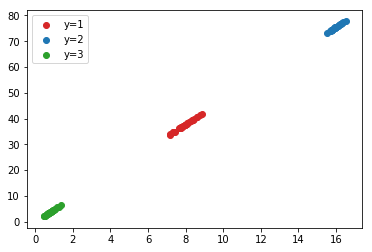

In [44]:
plt.scatter(x_pca_oja[:30, 0], x_pca_oja[:30, 1], color='tab:red', label='y=1')
plt.scatter(x_pca_oja[30:60, 0], x_pca_oja[30:60, 1], color='tab:blue', label='y=2')
plt.scatter(x_pca_oja[60:, 0], x_pca_oja[60:, 1], color='tab:green', label='y=3')
plt.legend(loc='upper left')

* The principal components seem to form a straight line, compared to the scikit-learn cloud points.

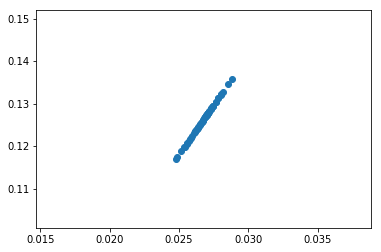

In [45]:
plt.scatter(w_out[:, 0], w_out[:, 1])

# Kaggle Submission

Essentially, I used Scikit-Learn linear SVC with different type of loss functions `['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']` and regularization scale `[0.0001, 0.01, 1]`.

In [77]:
%%file kaggle_0524.py
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
import os
import itertools
from scipy.stats import mode
from sklearn.svm import LinearSVC
from sklearn import linear_model
from tqdm import tqdm

def train_valid(model, X_train, y_train, X_valid, y_valid, method='ovo', **config):
    model_dict = {}
    train_preds = None
    valid_preds = None
    label_list = np.unique(y_train)
    if method == 'ovo':
        train_pred_list = []
        valid_pred_list = []
        label_pair_list = list(itertools.combinations(label_list, 2))
        for label_pair in tqdm(label_pair_list):
            mask = np.isin(y_train, label_pair)
            X_train_bin, y_train_bin = X_train[mask], y_train[mask]
            fit_model = model(**config).fit(X_train_bin, y_train_bin)
            model_dict['%i_%i' %(label_pair)] = fit_model
            valid_pred_bin = fit_model.predict(X_valid)
            valid_pred_list.append(valid_pred_bin)
        valid_preds = np.array([mode(pi).mode[0] for pi in np.array(valid_pred_list, dtype=np.int64).T])
    elif method == 'ovr':
        score_list = []
        for label in tqdm(label_list):
            y_train_bin = np.zeros_like(y_train) - 1
            y_train_bin[y_train == label] = 1
            fit_model = model(**config).fit(X_train, y_train_bin)
            model_dict['%i' %(label)] = fit_model
            train_scores = X_train.dot(fit_model.coef_)
            train_score_list.append(train_scores)
            valid_scores = X_valid.dot(fit_model.coef_)
            valid_score_list.append(valid_scores)
        train_preds = np.argmax(np.stack(train_score_list, axis=1), axis=1)
        valid_preds = np.argmax(np.stack(valid_score_list, axis=1), axis=1)
    else:
        print("Method Not Implemented")
    return model_dict, train_preds, valid_preds

def generate_test_preds(X_test, model_dict, method):
    test_preds = None
    if method == 'ovo':
        test_pred_list = []
        for label_pair, fit_model in tqdm(model_dict.items()):
            test_pred_bin = fit_model.predict(X_test)
            test_pred_list.append(test_pred_bin)
        test_preds = np.array([mode(pi).mode[0] for pi in np.array(test_pred_list, dtype=np.int64).T])
    elif method == 'ovr':
        score_list = []
        for label, fit_model in tqdm(model_dict.items()):
            test_scores = X_test.dot(fit_model.coef_)
            test_score_list.append(test_scores)
        test_preds = np.argmax(np.stack(test_score_list, axis=1), axis=1)
    else:
        print("Method Not Implemented")        
    return test_preds

if __name__ == '__main__':
    Ximg_train, yimg_train = np.load('data/train_features.npy'), np.load('data/train_labels.npy')
    print(Ximg_train.shape, yimg_train.shape)
    Ximg_valid, yimg_valid = np.load('data/val_features.npy'), np.load('data/val_labels.npy')
    print(Ximg_valid.shape, yimg_valid.shape)
    Ximg_test = np.load('data/test_features.npy')
    print(Ximg_test.shape)
    # Standardize the data
    scaler = preprocessing.StandardScaler().fit(Ximg_train)
    Ximg_train = scaler.transform(Ximg_train)
    Ximg_valid = scaler.transform(Ximg_valid)
    Ximg_test = scaler.transform(Ximg_test)
    n_train = Ximg_train.shape[0]
    cache_path = '../experiment_cache/0525'
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    for loss_type in ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']:
        for lam in [0.0001, 0.01, 1]:
            print('Loss type: %s. Lambda: %0.3f' %(loss_type, lam))
            ovo_model_dict, ovo_train_preds, ovo_valid_preds = train_valid(linear_model.SGDClassifier, Ximg_train, yimg_train, 
                                                                           Ximg_valid, yimg_valid, 
                                                                           method='ovo', **{'loss': loss_type, 'alpha': lam, 'max_iter': 50})
            pickle.dump({'md': ovo_model_dict}, open(os.path.join(cache_path, 'ovo_svc_%s_%0.3f.p' %(loss_type, lam)), 'wb'))
            print("Validation Error = %0.3f" %np.mean(ovo_valid_preds != yimg_valid))
            print("Saving Model...")
            cache = pickle.load(open(os.path.join(cache_path, 'ovo_svc_%s_%0.3f.p' %(loss_type, lam)), 'rb'))
            ovo_test_preds = generate_test_preds(Ximg_test, cache['md'], method='ovo')
            print("Generating CSV...")
            pd.DataFrame({'Category': ovo_test_preds}).to_csv(os.path.join(cache_path, 'kaggle_ovo_svc_%s_%0.3f.csv' %(loss_type, lam)), index_label='Id')

Overwriting kaggle_0524.py


In [78]:
%%file kaggle_multi_0525.py
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
import os
import itertools
from scipy.stats import mode
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from multiprocessing.dummy import Pool as ThreadPool
from tqdm import tqdm

def train_valid(model, X_train, y_train, X_valid, y_valid, method='ovo', **config):
    model_dict = {}
    train_preds = None
    valid_preds = None
    label_list = np.unique(y_train)
    if method == 'ovo':
        train_pred_list = []
        valid_pred_list = []
        label_pair_list = list(itertools.combinations(label_list, 2))
        for label_pair in tqdm(label_pair_list[:20]):
            mask = np.isin(y_train, label_pair)
            X_train_bin, y_train_bin = X_train[mask], y_train[mask]
            fit_model = model(**config).fit(X_train_bin, y_train_bin)
            model_dict['%i_%i' %(label_pair)] = fit_model
            valid_pred_bin = fit_model.predict(X_valid)
            valid_pred_list.append(valid_pred_bin)
        valid_preds = np.array([mode(pi).mode[0] for pi in np.array(valid_pred_list, dtype=np.int64).T])
    elif method == 'ovr':
        score_list = []
        for label in tqdm(label_list):
            y_train_bin = np.zeros_like(y_train) - 1
            y_train_bin[y_train == label] = 1
            fit_model = model(**config).fit(X_train, y_train_bin)
            model_dict['%i' %(label)] = fit_model
            train_scores = X_train.dot(fit_model.coef_)
            train_score_list.append(train_scores)
            valid_scores = X_valid.dot(fit_model.coef_)
            valid_score_list.append(valid_scores)
        train_preds = np.argmax(np.stack(train_score_list, axis=1), axis=1)
        valid_preds = np.argmax(np.stack(valid_score_list, axis=1), axis=1)
    else:
        print("Method Not Implemented")
    return model_dict, train_preds, valid_preds

def generate_test_preds(X_test, model_dict, method):
    test_preds = None
    if method == 'ovo':
        test_pred_list = []
        for label_pair, fit_model in tqdm(model_dict.items()):
            test_pred_bin = fit_model.predict(X_test)
            test_pred_list.append(test_pred_bin)
        test_preds = np.array([mode(pi).mode[0] for pi in np.array(test_pred_list, dtype=np.int64).T])
    elif method == 'ovr':
        score_list = []
        for label, fit_model in tqdm(model_dict.items()):
            test_scores = X_test.dot(fit_model.coef_)
            test_score_list.append(test_scores)
        test_preds = np.argmax(np.stack(test_score_list, axis=1), axis=1)
    else:
        print("Method Not Implemented")        
    return test_preds

if __name__ == '__main__':
    Ximg_train, yimg_train = np.load('data/train_features.npy'), np.load('data/train_labels.npy')
    print(Ximg_train.shape, yimg_train.shape)
    Ximg_valid, yimg_valid = np.load('data/val_features.npy'), np.load('data/val_labels.npy')
    print(Ximg_valid.shape, yimg_valid.shape)
    Ximg_test = np.load('data/test_features.npy')
    print(Ximg_test.shape)
    # Standardize the data
    scaler = preprocessing.StandardScaler().fit(Ximg_train)
    Ximg_train = scaler.transform(Ximg_train)
    Ximg_valid = scaler.transform(Ximg_valid)
    Ximg_test = scaler.transform(Ximg_test)
    n_train = Ximg_train.shape[0]
    cache_path = '../.cache/0525'
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    for kernel_type in ['poly', 'rbf', 'sigmoid']:
        for lam in [0.01, 0.1, 1]:
            print('Kernel type %s. Lambda = %0.3f' %(kernel_type, lam))
#             pool = ThreadPool(36)
#             ovo_model_dict, ovo_train_preds, ovo_valid_preds = pool.apply_async(train_valid, (SVC, Ximg_train, yimg_train, Ximg_valid, yimg_valid, 'ovo'),
#                                                                                [{'kernel': kernel_type, 'C': lam}])
            ovo_model_dict, ovo_train_preds, ovo_valid_preds = train_valid(SVC, Ximg_train, yimg_train, 
                                                                           Ximg_valid, yimg_valid, 
                                                                           method='ovo', **{'kernel': kernel_type, 'C': lam})
            pickle.dump({'md': ovo_model_dict}, open(os.path.join(cache_path, 'ovo_svc_%s_%0.3f.p' %(kernel_type, lam)), 'wb'))
            print("Validation Error = %0.3f" %np.mean(ovo_valid_preds != yimg_valid))
            print("Saving Model...")
            cache = pickle.load(open(os.path.join(cache_path, 'ovo_svc_%s_%i_0525.p' %(kernel_type, lam)), 'rb'))
            ovo_test_preds = generate_test_preds(Ximg_test, cache['md'], method='ovo')
            print("Generating CSV...")
            pd.DataFrame({'Category': ovo_test_preds}).to_csv(os.path.join(cache_path, 'kaggle_ovo_svc_%s_%0.3f.csv' %(kernel_type, lam)), index_label='Id')

Writing kaggle_multi_0525.py


In [2]:
%%file kaggle_svc_kernel_0525.py
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
import os
import itertools
from scipy.stats import mode
from sklearn.svm import LinearSVC
from tqdm import tqdm

def train_valid(model, X_train, y_train, X_valid, y_valid, method='ovo', **config):
    model_dict = {}
    train_preds = None
    valid_preds = None
    label_list = np.unique(y_train)
    if method == 'ovo':
        train_pred_list = []
        valid_pred_list = []
        label_pair_list = list(itertools.combinations(label_list, 2))
        for label_pair in tqdm(label_pair_list[:20]):
            mask = np.isin(y_train, label_pair)
            X_train_bin, y_train_bin = X_train[mask], y_train[mask]
            fit_model = model(**config).fit(X_train_bin, y_train_bin)
            model_dict['%i_%i' %(label_pair)] = fit_model
            valid_pred_bin = fit_model.predict(X_valid)
            valid_pred_list.append(valid_pred_bin)
        valid_preds = np.array([mode(pi).mode[0] for pi in np.array(valid_pred_list, dtype=np.int64).T])
    elif method == 'ovr':
        score_list = []
        for label in tqdm(label_list):
            y_train_bin = np.zeros_like(y_train) - 1
            y_train_bin[y_train == label] = 1
            fit_model = model(**config).fit(X_train, y_train_bin)
            model_dict['%i' %(label)] = fit_model
            train_scores = X_train.dot(fit_model.coef_)
            train_score_list.append(train_scores)
            valid_scores = X_valid.dot(fit_model.coef_)
            valid_score_list.append(valid_scores)
        train_preds = np.argmax(np.stack(train_score_list, axis=1), axis=1)
        valid_preds = np.argmax(np.stack(valid_score_list, axis=1), axis=1)
    else:
        print("Method Not Implemented")
    return model_dict, train_preds, valid_preds

def generate_test_preds(X_test, model_dict, method):
    test_preds = None
    if method == 'ovo':
        test_pred_list = []
        for label_pair, fit_model in tqdm(model_dict.items()):
            test_pred_bin = fit_model.predict(X_test)
            test_pred_list.append(test_pred_bin)
        test_preds = np.array([mode(pi).mode[0] for pi in np.array(test_pred_list, dtype=np.int64).T])
    elif method == 'ovr':
        score_list = []
        for label, fit_model in tqdm(model_dict.items()):
            test_scores = X_test.dot(fit_model.coef_)
            test_score_list.append(test_scores)
        test_preds = np.argmax(np.stack(test_score_list, axis=1), axis=1)
    else:
        print("Method Not Implemented")        
    return test_preds

if __name__ == '__main__':
    Ximg_train, yimg_train = np.load('data/train_features.npy'), np.load('data/train_labels.npy')
    print(Ximg_train.shape, yimg_train.shape)
    Ximg_valid, yimg_valid = np.load('data/val_features.npy'), np.load('data/val_labels.npy')
    print(Ximg_valid.shape, yimg_valid.shape)
    Ximg_test = np.load('data/test_features.npy')
    print(Ximg_test.shape)
    # Standardize the data
    scaler = preprocessing.StandardScaler().fit(Ximg_train)
    Ximg_train = scaler.transform(Ximg_train)
    Ximg_valid = scaler.transform(Ximg_valid)
    Ximg_test = scaler.transform(Ximg_test)
    n_train = Ximg_train.shape[0]
    cache_path = '../.cache/0525'
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    lambda_list = np.logspace(start=-10, stop=5, num=10, base=2)
    for lam in lambda_list:
        print('Lambda = %0.3f' %(lam))
        ovo_model_dict, ovo_train_preds, ovo_valid_preds = train_valid(LinearSVC, Ximg_train, yimg_train, 
                                                                       Ximg_valid, yimg_valid, 
                                                                       method='ovo', **{'C': lam})
        ovo_test_preds = generate_test_preds(Ximg_test, ovo_model_dict, method='ovo')
        print("Generating CSV...")
        pd.DataFrame({'Category': ovo_test_preds}).to_csv(os.path.join(cache_path, 'kaggle_ovo_linear_svc_%0.3f.csv' %(lam)), index_label='Id')

Writing kaggle_svc_kernel_0525.py


In [20]:
%%file kaggle_multimodel.py
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import itertools
from scipy.stats import mode
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tqdm import tqdm

def train_valid(model, X_train, y_train, X_valid, y_valid, method='ovo'):
    model_dict = {}
    train_preds = None
    valid_preds = None
    label_list = np.unique(y_train)
    if method == 'ovo':
        train_pred_list = []
        valid_pred_list = []
        label_pair_list = list(itertools.combinations(label_list, 2))
        for label_pair in tqdm(label_pair_list[:20]):
            mask = np.isin(y_train, label_pair)
            X_train_bin, y_train_bin = X_train[mask], y_train[mask]
            fit_model = model.fit(X_train_bin, y_train_bin)
            model_dict['%i_%i' %(label_pair)] = fit_model
            valid_pred_bin = fit_model.predict(X_valid)
            valid_pred_list.append(valid_pred_bin)
        valid_preds = np.array([mode(pi).mode[0] for pi in np.array(valid_pred_list, dtype=np.int64).T])
    elif method == 'ovr':
        score_list = []
        for label in tqdm(label_list):
            y_train_bin = np.zeros_like(y_train) - 1
            y_train_bin[y_train == label] = 1
            fit_model = model.fit(X_train, y_train_bin)
            model_dict['%i' %(label)] = fit_model
            train_scores = X_train.dot(fit_model.coef_)
            train_score_list.append(train_scores)
            valid_scores = X_valid.dot(fit_model.coef_)
            valid_score_list.append(valid_scores)
        train_preds = np.argmax(np.stack(train_score_list, axis=1), axis=1)
        valid_preds = np.argmax(np.stack(valid_score_list, axis=1), axis=1)
    else:
        print("Method Not Implemented")
    return model_dict, train_preds, valid_preds

def generate_test_preds(X_test, model_dict, method):
    test_preds = None
    if method == 'ovo':
        test_pred_list = []
        for label_pair, fit_model in tqdm(model_dict.items()):
            test_pred_bin = fit_model.predict(X_test)
            test_pred_list.append(test_pred_bin)
        test_preds = np.array([mode(pi).mode[0] for pi in np.array(test_pred_list, dtype=np.int64).T])
    elif method == 'ovr':
        score_list = []
        for label, fit_model in tqdm(model_dict.items()):
            test_scores = X_test.dot(fit_model.coef_)
            test_score_list.append(test_scores)
        test_preds = np.argmax(np.stack(test_score_list, axis=1), axis=1)
    else:
        print("Method Not Implemented")        
    return test_preds

if __name__ == '__main__':
    Ximg_train, yimg_train = np.load('data/train_features.npy'), np.load('data/train_labels.npy')
    print(Ximg_train.shape, yimg_train.shape)
    Ximg_valid, yimg_valid = np.load('data/val_features.npy'), np.load('data/val_labels.npy')
    print(Ximg_valid.shape, yimg_valid.shape)
    Ximg_test = np.load('data/test_features.npy')
    print(Ximg_test.shape)
    # Standardize the data
    scaler = preprocessing.StandardScaler().fit(Ximg_train)
    Ximg_train = scaler.transform(Ximg_train)
    Ximg_valid = scaler.transform(Ximg_valid)
    Ximg_test = scaler.transform(Ximg_test)
    n_train = Ximg_train.shape[0]
    cache_path = '../cache/0525'
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    classifiers_list = {'knn': KNeighborsClassifier(3), 'decision_tree': DecisionTreeClassifier(max_depth=5),
                        'rf': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                        'mlp': MLPClassifier(alpha=1), 
                        'ada': AdaBoostClassifier(), 
                        'gaussian': GaussianNB(), 
                        'qda': QuadraticDiscriminantAnalysis()
                       }
    for model_name, classifier in classifiers_dict.items():
        print('Model Name: %s' %(model_name))
        ovo_model_dict, ovo_train_preds, ovo_valid_preds = train_valid(SVC, Ximg_train, yimg_train, 
                                                                   Ximg_valid, yimg_valid, 
                                                                   method='ovo')
        pickle.dump({'md': ovo_model_dict}, open(os.path.join(cache_path, 'kaggle_multi_%s.csv' %(model_name)), 'wb'))
        print("Validation Error = %0.3f" %np.mean(ovo_valid_preds != yimg_valid))
        # print("Saving Model...")
        # cache = pickle.load(open(os.path.join(cache_path, 'ovo_svc_%s_%i_0525.p' %(kernel_type, lam)), 'rb'))
        # ovo_model_dict = cache['md']
        ovo_test_preds = generate_test_preds(Ximg_test, ovo_model_dict, method='ovo')
        print("Generating CSV...")
        pd.DataFrame({'Category': ovo_test_preds}).to_csv(os.path.join(cache_path, 'kaggle_multi_%s.csv' %(model_name)), index_label='Id')

Writing kaggle_multimodel.py


In [9]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [14]:
names2 = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [17]:
list(zip(names, classifiers, names2))

[('Nearest Neighbors', 0, 'Nearest Neighbors'),
 ('Linear SVM', 1, 'Linear SVM'),
 ('RBF SVM', 2, 'RBF SVM'),
 ('Gaussian Process', 3, 'Gaussian Process'),
 ('Decision Tree', 4, 'Decision Tree'),
 ('Random Forest', 5, 'Random Forest'),
 ('Neural Net', 6, 'Neural Net'),
 ('AdaBoost', 7, 'AdaBoost'),
 ('Naive Bayes', 8, 'Naive Bayes'),
 ('QDA', 9, 'QDA')]

In [18]:
a = [1, 2, 3, 4, 5]
b = [4, 5, 6, 7, 8]
d = [{'a':1}, {'a':6}, {'a':1}, {'a':5}, {'a':4}]
m = list(zip(a, b, d))

In [19]:
for k in m:
    print(k[0])
    print(k[1])
    print(type(k[2]))
    print(k[2])

1
4
<class 'dict'>
{'a': 1}
2
5
<class 'dict'>
{'a': 6}
3
6
<class 'dict'>
{'a': 1}
4
7
<class 'dict'>
{'a': 5}
5
8
<class 'dict'>
{'a': 4}
